In [25]:
#setting path
DATA_PATH = r"C:\Users\HP\Downloads\PRCP-1007-LiverPatientPred\Data\Indian Liver Patient Dataset (ILPD).csv"
print("Trying to read:", DATA_PATH)

Trying to read: C:\Users\HP\Downloads\PRCP-1007-LiverPatientPred\Data\Indian Liver Patient Dataset (ILPD).csv


In [64]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# imblearn for oversampling (install imbalance-Learn if not present)
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError("imblearn not installed. Install with: pip install imbalanced-learn") from e

    

In [27]:
!pip install imbalanced-learn

In [31]:
# LOAD DATA (force no header, then assign correct ones manually)
df = pd.read_csv(DATA_PATH, header=None)


In [32]:
# Assign proper column names (from UCI ILPD dataset description)
df.columns = [
    'Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
    'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
    'Aspartate_Aminotransferase', 'Total_Protiens',
    'Albumin', 'Albumin_and_Globulin_Ratio', 'Dataset'
]

In [33]:
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (583, 11)


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [34]:
# QUICK DATA CHECK
print("\n--- Info ---")
display(df.info())
print("\n--- Numeric summary ---")
display(df.describe().T)
print("\n--- Missing values per column ---")
print(df.isna().sum())



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


None


--- Numeric summary ---


,count,mean,std,min,25%,50%,75%,max
Age,583.0,44.746141,16.189833,4.0,33.0,45.00,58.0,90.0
Total_Bilirubin,583.0,3.298799,6.209522,0.4,0.8,1.00,2.6,75.0
Direct_Bilirubin,583.0,1.486106,2.808498,0.1,0.2,0.30,1.3,19.7
Alkaline_Phosphotase,583.0,290.576329,242.937989,63.0,175.5,208.00,298.0,2110.0
Alamine_Aminotransferase,583.0,80.713551,182.620356,10.0,23.0,35.00,60.5,2000.0
Aspartate_Aminotransferase,583.0,109.910806,288.918529,10.0,25.0,42.00,87.0,4929.0
Total_Protiens,583.0,6.483190,1.085451,2.7,5.8,6.60,7.2,9.6
Albumin,583.0,3.141852,0.795519,0.9,2.6,3.10,3.8,5.5
Albumin_and_Globulin_Ratio,579.0,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8
Dataset,583.0,1.286449,0.452490,1.0,1.0,1.00,2.0,2.0



--- Missing values per column ---
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64


In [35]:
# TARGET & CATEGORICAL PREP
# Map Dataset: 1 = liver disease, 0 = no disease
df['Dataset'] = df['Dataset'].astype(int).map({1:1, 2:0})
df.rename(columns={'Dataset': 'Target'}, inplace=True)
print("\nTarget unique values:", df['Target'].unique())

# Gender encoding if present
if 'Gender' in df.columns:
    if df['Gender'].dtype == object:
        df['Gender'] = df['Gender'].str.strip().map({
            'Male':1, 'Male ':1, 'M':1,
            'Female':0, 'female':0, 'F':0
        })
    print("\nGender value counts:\n", df['Gender'].value_counts(dropna=False))


Target unique values: [1 0]

Gender value counts:
 Gender
1    441
0    142
Name: count, dtype: int64


In [39]:
#HANDLE MISSING VALUE
# Strategy: median imputation for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'Target']
print("\nNumeric columns:", num_cols)

for c in num_cols:
    if df[c].isna().sum() > 0:
        med = df[c].median()
        df[c].fillna(med, inplace=True)
        print(f"Filled NA in {c} with median = {med}")

print("\nMissing values after imputation:\n", df.isna().sum())


Numeric columns: ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']
Filled NA in Albumin_and_Globulin_Ratio with median = 0.93

Missing values after imputation:
 Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Target                        0
dtype: int64


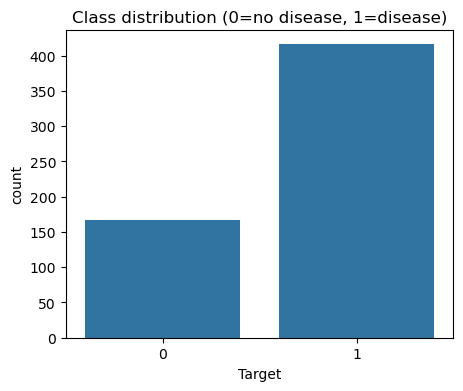

In [44]:
# EDA (brief)
plt.figure(figsize=(5,4))
sns.countplot(x='Target', data=df)
plt.title("Class distribution (0=no disease, 1=disease)")
plt.show()


         

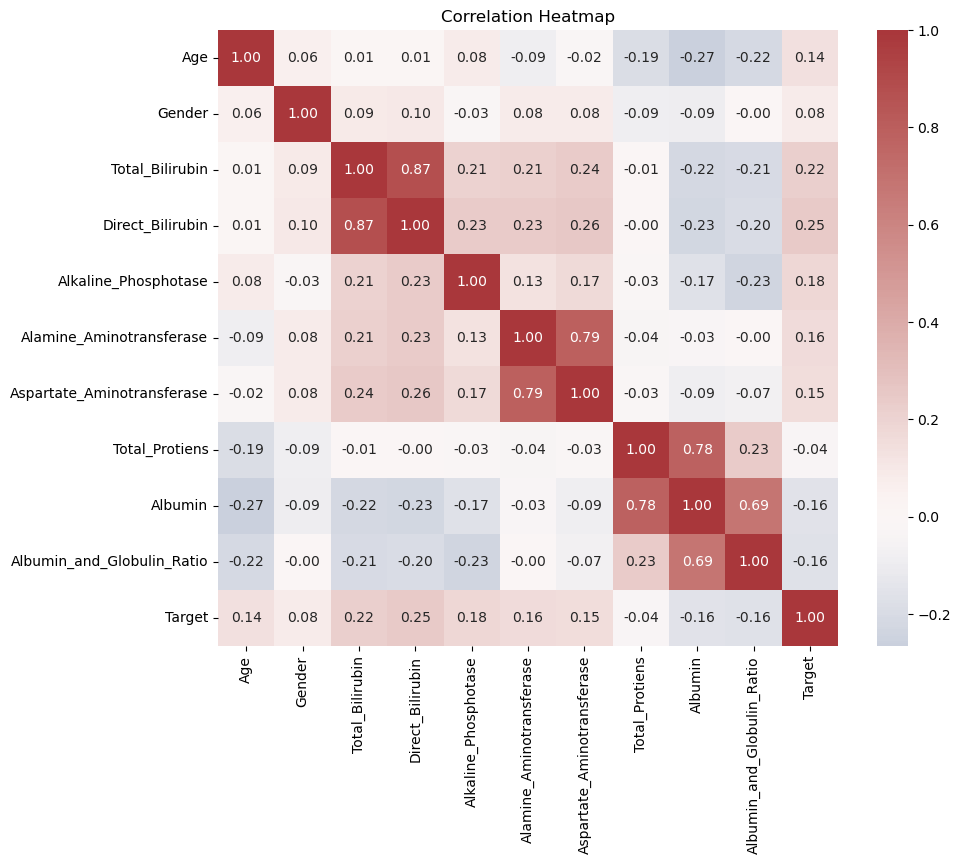

In [45]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [46]:
# FEATURES AND TARGET
X = df.drop(columns=['Target'])
y = df['Target'].astype(int)

In [50]:
# TRAIN TEST SPLIT (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain class proportions:\n", y_train.value_counts(normalize=True))
print("\nTest class proportions:\n", y_test.value_counts(normalize=True))



Train class proportions:
 Target
1    0.714592
0    0.285408
Name: proportion, dtype: float64

Test class proportions:
 Target
1    0.709402
0    0.290598
Name: proportion, dtype: float64


In [53]:
#IMBALANCE HANDLING  - SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE, train counts:\n", pd.Series(y_train_res).value_counts())


After SMOTE, train counts:
 Target
1    333
0    333
Name: count, dtype: int64


In [58]:
#SCALING (necessary for KNN)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

#convert vack to Dataframe for readability
X_train_res_scaled = pd.DataFrame(X_train_res_scaled, columns=X.columns)
X_test_svaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [69]:
#HELPER: VALIDATE PARAM GRID KEYS
def validate_param_grid(estimator, param_grid):
    valid = set(estimator.get_params().keys())
    bad_keys = [k for k in param_grid.keys() if k not in valid]
    if bad_keys:
        raise ValueError(f"Invalid param keys: {bad_keys}\nValid keys include: {sorted(list(valid))[:30]} ...")
    print("Param grid keys validated for", estimator.__class__.__name__)


In [70]:
# MODEL SETUP & HYPERPARAMETER GRIDS
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [73]:
# KNN 
knn = KNeighborsClassifier()
knn_param_grid_quick = {
    'n_neighbors': [3,5],        # quick test
    'weights': ['uniform','distance'],
    'p': [1,2]
}
knn_param_grid_full = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform','distance'],
    'p': [1,2]
}


In [74]:
# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
xgb_param_grid_quick = {
    'n_estimators': [50,100],
    'max_depth': [3,4],
    'learning_rate': [0.05, 0.1]
}
xgb_param_grid_full = {
    'n_estimators': [50,100,150],
    'max_depth': [3,4,6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [75]:
# Validate param grids (quick)
validate_param_grid(knn, knn_param_grid_quick)
validate_param_grid(xgb_clf, xgb_param_grid_quick)


Param grid keys validated for KNeighborsClassifier
Param grid keys validated for XGBClassifier


In [76]:
#GRID SEARCH (quick test grids first)
print("\nStarting quick GridSearch for KNN...")
knn_gs = GridSearchCV(knn, knn_param_grid_quick, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
knn_gs.fit(X_train_res_scaled, y_train_res)
print("KNN best params (quick):", knn_gs.best_params_)
print("KNN best CV F1 (quick):", knn_gs.best_score_)

print("\nStarting quick GridSearch for XGBoost...")
xgb_gs = GridSearchCV(xgb_clf, xgb_param_grid_quick, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
xgb_gs.fit(X_train_res, y_train_res)
print("XGBoost best params (quick):", xgb_gs.best_params_)
print("XGBoost best CV F1 (quick):", xgb_gs.best_score_)

# If quick runs succeed, you can rerun using full grids:
# knn_gs = GridSearchCV(knn, knn_param_grid_full, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
# knn_gs.fit(X_train_res_scaled, y_train_res)
# xgb_gs = GridSearchCV(xgb_clf, xgb_param_grid_full, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
# xgb_gs.fit(X_train_res, y_train_res)



Starting quick GridSearch for KNN...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN best params (quick): {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNN best CV F1 (quick): 0.6892060229302587

Starting quick GridSearch for XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost best params (quick): {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
XGBoost best CV F1 (quick): 0.7706806174516996


In [78]:
#EVALUATE BEST MODELS ON TEST SET
best_knn = knn_gs.best_estimator_
best_xgb = xgb_gs.best_estimator_

# KNN predictions (use scaled test)
y_pred_knn = best_knn.predict(X_test_scaled)
y_proba_knn = best_knn.predict_proba(X_test_scaled)[:,1] if hasattr(best_knn, "predict_proba") else None

# XGBoost predictions (use original test features)
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]

def metrics_summary(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba) if (y_proba is not None) else np.nan
    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':roc}
    
metrics_knn = metrics_summary(y_test, y_pred_knn, y_proba_knn)
metrics_xgb = metrics_summary(y_test, y_pred_xgb, y_proba_xgb)

results_df = pd.DataFrame([metrics_knn, metrics_xgb], index=['KNN','XGBoost'])
print("\n--- Test set metrics ---")
display(results_df)


--- Test set metrics ---


,accuracy,precision,recall,f1,roc_auc
KNN,0.615385,0.771429,0.650602,0.705882,0.724486
XGBoost,0.709402,0.781609,0.819277,0.800000,0.756201


In [79]:
# DETAILED REPORTS
print("\nKNN Classification Report:\n")
print(classification_report(y_test, y_pred_knn, zero_division=0))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



KNN Classification Report:

              precision    recall  f1-score   support

           0       0.38      0.53      0.44        34
           1       0.77      0.65      0.71        83

    accuracy                           0.62       117
   macro avg       0.58      0.59      0.58       117
weighted avg       0.66      0.62      0.63       117

KNN Confusion Matrix:
 [[18 16]
 [29 54]]

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.44      0.47        34
           1       0.78      0.82      0.80        83

    accuracy                           0.71       117
   macro avg       0.64      0.63      0.63       117
weighted avg       0.70      0.71      0.70       117

XGBoost Confusion Matrix:
 [[15 19]
 [15 68]]


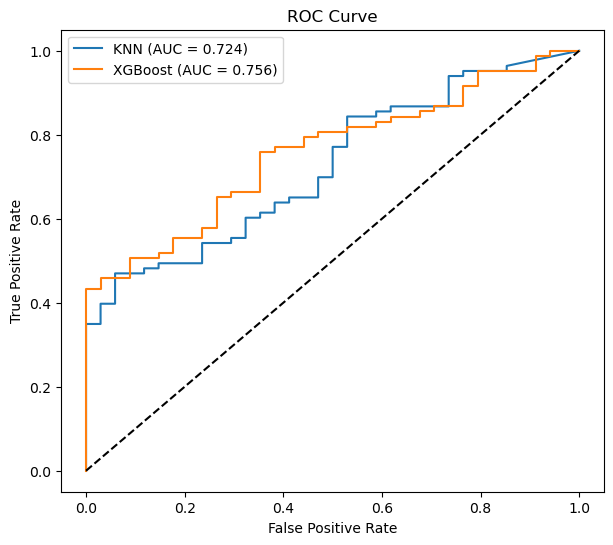

In [80]:
# ROC CURVES
plt.figure(figsize=(7,6))
if y_proba_knn is not None:
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
    auc_knn = roc_auc_score(y_test, y_proba_knn)
    plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

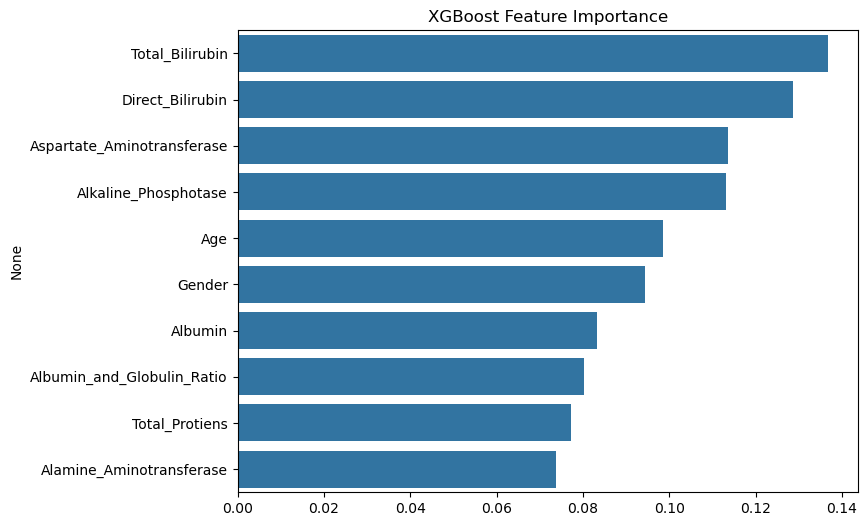

In [81]:
#  FEATURE IMPORTANCE (XGBoost)
fi = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi.values, y=fi.index)
plt.title("XGBoost Feature Importance")
plt.show()


In [82]:
# SAVE MODELS & SCALER
joblib.dump(best_xgb, "best_xgb_liver_model.joblib")
joblib.dump(best_knn, "best_knn_liver_model.joblib")
joblib.dump(scaler, "scaler_for_knn.joblib")
print("\nSaved: best_xgb_liver_model.joblib, best_knn_liver_model.joblib, scaler_for_knn.joblib")


Saved: best_xgb_liver_model.joblib, best_knn_liver_model.joblib, scaler_for_knn.joblib


In [83]:
#  SHORT CONCLUSION
print("\n--- Short Conclusion ---")
if results_df.loc['XGBoost','f1'] >= results_df.loc['KNN','f1']:
    print("XGBoost performs better based on F1 on the test set. Recommend XGBoost for production (consider calibration and explainability).")
else:
    print("KNN performs better based on F1 on the test set. KNN is simpler but may not scale for large production datasets.")


--- Short Conclusion ---
XGBoost performs better based on F1 on the test set. Recommend XGBoost for production (consider calibration and explainability).
